# V39 Butylacetate Conformer Analysis

This notebook demonstrates how to use the `molconfgen.workflows.conformer_to_energies` workflow
for compound V39 (butylacetate) and analyze the resulting conformer energies and dihedral angles.

## Workflow Overview

1. Load V39 data files from `molconfgen.data.files`
2. Run the `conformer_to_energies` workflow to generate conformers and calculate energies
3. Extract dihedral angles from the generated trajectory
4. Analyze and visualize energy landscapes as functions of dihedral angles

## Key Features

- Uses only data files from `molconfgen.data.files` (no SANDBOX directory)
- Demonstrates complete conformer generation and energy calculation workflow
- Extracts dihedral angles used by the conformer generator
- Creates energy vs dihedral angle plots
- Generates 2D energy density plots for dihedral pairs


## Setup and Imports


In [1]:
# Core packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tempfile
import os

# MDAnalysis and RDKit
import MDAnalysis as mda
import rdkit
from rdkit import Chem

# molconfgen modules
from molconfgen import workflows, analyze, chem
from molconfgen.data.files import V39_PDB, V39_ITP, V39_TOP

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print(f"MDAnalysis version: {mda.__version__}")
print(f"RDKit version: {rdkit.__version__}")
print(f"V39 data files:")
print(f"  PDB: {V39_PDB}")
print(f"  ITP: {V39_ITP}")
print(f"  TOP: {V39_TOP}")


MDAnalysis version: 2.9.0
RDKit version: 2024.03.5
V39 data files:
  PDB: /Volumes/ASU/oliver/Projects/Methods/SmallMoleculeSolvation/mdpow-molconfgen/molconfgen/data/V39-butylacetate/V39-butylacetate.pdb
  ITP: /Volumes/ASU/oliver/Projects/Methods/SmallMoleculeSolvation/mdpow-molconfgen/molconfgen/data/V39-butylacetate/V39-butylacetate.itp
  TOP: /Volumes/ASU/oliver/Projects/Methods/SmallMoleculeSolvation/mdpow-molconfgen/molconfgen/data/V39-butylacetate/V39.top


/Users/oliver/anaconda3/envs/mdpow312tst/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


## Load V39 Molecule and Examine Structure


V39 molecule info:
  Number of atoms: 20
  Atom names: ['C1', 'O2', 'O7', 'C3', 'H9', 'H10', 'H18', 'H19', 'H20', 'C6', 'H15', 'H16', 'H17', 'C8', 'C4', 'H11', 'H12', 'C5', 'H13', 'H14']
  Molecular formula: C6H12O2


/Users/oliver/anaconda3/envs/mdpow312tst/lib/python3.12/site-packages/MDAnalysis/topology/ITPParser.py:646: DeprecationWarning: The elements attribute has been populated by guessing elements from atom types. This behaviour has been temporarily added to the ITPParser as we transition to the new guessing API. This behavior will be removed in release 3.0. Please see issue #4698 for more information. 
  warnings.warn(
/Users/oliver/anaconda3/envs/mdpow312tst/lib/python3.12/site-packages/MDAnalysis/topology/guessers.py:184: DeprecationWarning: `guess_atom_element` is deprecated!
`guess_atom_element` will be removed in release 3.0.0.
MDAnalysis.topology.guessers is deprecated in favour of the new Guessers API. See MDAnalysis.guesser.default_guesser for more details.
  [guess_atom_element(name) for name in atom_names], dtype=object


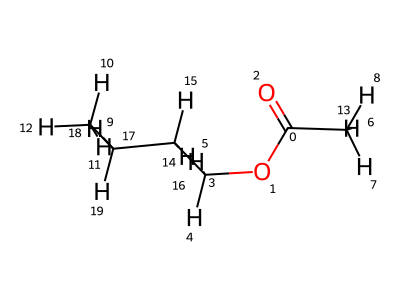

In [2]:
# Load the V39 molecule
universe = mda.Universe(str(V39_ITP), str(V39_PDB))
mol = chem.load_mol(universe, add_labels=True)

print(f"V39 molecule info:")
print(f"  Number of atoms: {universe.atoms.n_atoms}")
print(f"  Atom names: {list(universe.atoms.names)}")
print(f"  Molecular formula: {Chem.rdMolDescriptors.CalcMolFormula(mol)}")

# Display the molecule structure (generate coordinates by RDKit for cleaner layout)
from rdkit.Chem import Draw, AllChem

AllChem.EmbedMolecule(mol, randomSeed=42)
AllChem.MMFFOptimizeMolecule(mol)

Draw.MolToImage(mol, size=(400, 300))


## Identify Dihedral Angles

Let's identify the dihedral angles that will be sampled by the conformer generator:


In [3]:
# reload the molecule
mol = chem.load_mol(universe, add_labels=True)

# Find dihedral angles that the conformer generator will use
dihedral_indices = chem.find_dihedral_indices(mol, unique=True)
dihedrals = chem.find_dihedrals(mol, universe, unique=True)

print(f"Found {len(dihedral_indices)} unique dihedral angles:")
for i, (indices, dihedral) in enumerate(zip(dihedral_indices, dihedrals)):
    atom_names = [universe.atoms[idx].name for idx in indices]
    print(f"  Dihedral {i+1}: atoms {indices} ({'-'.join(atom_names)})")
    print(f"    Current angle: {dihedral.value():.1f}°")

num_dihedrals = len(dihedral_indices)
print(f"\nTotal number of dihedrals (M): {num_dihedrals}")


Found 4 unique dihedral angles:
  Dihedral 1: atoms [2 0 1 3] (O7-C1-O2-C3)
    Current angle: -0.1°
  Dihedral 2: atoms [ 0  1  3 14] (C1-O2-C3-C4)
    Current angle: -180.0°
  Dihedral 3: atoms [ 1  3 14 17] (O2-C3-C4-C5)
    Current angle: 180.0°
  Dihedral 4: atoms [ 3 14 17  9] (C3-C4-C5-C6)
    Current angle: -180.0°

Total number of dihedrals (M): 4


## Run the Conformer-to-Energies Workflow

Now we'll use the `conformer_to_energies` workflow to generate conformers and calculate their energies:


In [ ]:
# Create a temporary directory for output files
output_dir = Path("V39_conformer_analysis_output")
output_dir.mkdir(exist_ok=True)

# Set up parameters for conformer generation
num_conformers = 12   # number of conformers per dihedral angle
output_prefix = str(output_dir / "V39_conformers")

print(f"Running conformer_to_energies workflow...")
print(f"  Number of conformers per dihedral angle: {num_conformers}")
print(f"  Number of dihedral angles: {num_dihedrals}")
print(f"  Number of conformers: {num_conformers ** num_dihedrals}")
print(f"  Output prefix: {output_prefix}")

# Run the workflow
result = workflows.conformers_to_energies(
    itp_file=str(V39_ITP),
    pdb_file=str(V39_PDB),
    top_file=str(V39_TOP),
    num_conformers=num_conformers,
    output_prefix=output_prefix
)

print(f"\nWorkflow completed! Generated files:")
for key, filepath in result.items():
    print(f"  {key}: {filepath}")
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / 1024  # KB
        print(f"    (Size: {size:.1f} KB)")
    else:
        print(f"    (File not found!)")


Running conformer_to_energies workflow...
  Number of conformers per dihedral angle: 12
  Number of dihedral angles: 4
  Number of conformers: 20736
  Output prefix: V39_conformer_analysis_output/V39_conformers


  0%|          | 0/20736 [00:00<?, ?it/s]

/Users/oliver/anaconda3/envs/mdpow312tst/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/oliver/anaconda3/envs/mdpow312tst/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/oliver/anaconda3/envs/mdpow312tst/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/Users/oliver/anaconda3/envs/mdpow312tst/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/Users/oliver/anaconda3/envs/md

Setting the LD random seed to -4721801

Generated 330891 of the 330891 non-bonded parameter combinations

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'V39'
Analysing residue names:
There are:     1      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

This run will generate roughly 0 Mb of data


                :-) GROMACS - gmx mdrun, 2024.5-conda_forge (-:

Executable:   /Users/oliver/anaconda3/envs/mdpow312tst/bin.AVX2_256/gmx
Data prefix:  /Users/oliver/anaconda3/envs/mdpow312tst
Working dir:  /Volumes/ASU/oliver/Projects/Methods/SmallMoleculeSolvation/mdpow-molconfgen/notebooks
Command line:
  gmx mdrun -s V39_conformer_analysis_output/V39_conformers_topol.tpr -rerun V39_conformer_analysis_output/V39_conformers_conformers.trr -o V39_conformer_analysis_output/V39_conformers_traj.trr -e V39_conformer_analysis_output/V39_conformers_ener.edr


Back Off! I just backed up md.log to ./#md.log.1#
The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file V39_conformer_analysis_output/V39_conformers_topol.tpr, VERSION 2024.5-conda_forge (single precision)

NOT


Workflow completed! Generated files:
  topology: V39_conformer_analysis_output/V39_conformers_topol.tpr
    (Size: 8.7 KB)
  conformers: V39_conformer_analysis_output/V39_conformers_conformers.trr
    (Size: 7290.0 KB)
  energies: V39_conformer_analysis_output/V39_conformers_ener.edr
    (Size: 2187.2 KB)




NOTE: 32 % of the run time was spent in pair search,
      you might want to increase nstlist (this has no effect on accuracy)

               Core t (s)   Wall t (s)        (%)
       Time:       16.168        2.021      799.8
                 (ns/day)    (hour/ns)
Performance:     1772.567        0.014

GROMACS reminds you: "Everything Must Go" (Red Hot Chili Peppers)



In [6]:
result

{'topology': 'V39_conformer_analysis_output/V39_conformers_topol.tpr',
 'conformers': 'V39_conformer_analysis_output/V39_conformers_conformers.trr',
 'energies': 'V39_conformer_analysis_output/V39_conformers_ener.edr'}

## Extract Dihedral Angles and Energies

Now we'll extract the dihedral angles and energies from the generated trajectory:


In [7]:
# Extract dihedral angles and energies using the analyze module
angles, energies = analyze.analyze_conformers(
    topology_file=result["topology"],
    trajectory_file=result["conformers"],
    energy_file=result["energies"],
    verbose=True,
)

print(f"Extracted data:")
print(f"  Angles shape: {angles.shape}")
print(f"  Energies shape: {energies.shape}")
print(f"  Number of conformers: {len(energies)}")
print(f"  Number of dihedrals: {angles.shape[1] if len(angles.shape) > 1 else 1}")

# Convert energies to relative energies (in kJ/mol)
relative_energies = energies - np.min(energies)

print(f"\nEnergy statistics:")
print(f"  Min energy: {np.min(energies):.2f} kJ/mol")
print(f"  Max energy: {np.max(energies):.2f} kJ/mol")
print(f"  Energy range: {np.max(relative_energies):.2f} kJ/mol")
print(f"  Mean energy: {np.mean(energies):.2f} kJ/mol")
print(f"  Std energy: {np.std(energies):.2f} kJ/mol")


/Users/oliver/anaconda3/envs/mdpow312tst/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:253: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn(


  0%|          | 0/20736 [00:00<?, ?it/s]

Extracted data:
  Angles shape: (20736, 4)
  Energies shape: (20736,)
  Number of conformers: 20736
  Number of dihedrals: 4

Energy statistics:
  Min energy: 26.44 kJ/mol
  Max energy: 206021644089556992.00 kJ/mol
  Energy range: 206021644089556960.00 kJ/mol
  Mean energy: 19579521800793.20 kJ/mol
  Std energy: 1582992541072544.00 kJ/mol


## Data Arrays

The dihedrals and energies
- M = number of dihedrals
- N = number of conformers

are stored in
- `angles`: each row describes the dihedrals of the corresponding trajectory frame at the same index
- `energies`: each entry is the energy of the frame


In [8]:
angles.shape, energies.shape

((20736, 4), (20736,))

In [9]:
np.save('V39_angles.npy', angles)
np.save('V39_energies.npy', energies)

## Energy vs Individual Dihedral Angles

Plot the energy for each individual dihedral, averaged over all other dihedrals:


In [10]:
# Use the existing angles and energies arrays directly
# angles has shape (N, M) where N = number of conformers, M = number of dihedrals
# energies has shape (N,) where N = number of conformers

M = angles.shape[1]  # number of dihedrals
N = angles.shape[0]  # number of conformers

print(f"Data overview:")
print(f"  angles shape: {angles.shape} (N={N} conformers, M={M} dihedrals)")
print(f"  energies shape: {energies.shape}")
print(f"  angles[i, j] = j-th dihedral angle for i-th conformer")
print(f"  energies[i] = energy for i-th conformer")

# Display sample of the data
print(f"\nSample data (first 5 conformers):")
for j in range(M):
    print(f"  Dihedral {j+1}: {angles[:5, j]}")
print(f"  Energies:     {relative_energies[:5]}")


Data overview:
  angles shape: (20736, 4) (N=20736 conformers, M=4 dihedrals)
  energies shape: (20736,)
  angles[i, j] = j-th dihedral angle for i-th conformer
  energies[i] = energy for i-th conformer

Sample data (first 5 conformers):
  Dihedral 1: [-0.05491439 -0.05491439 -0.05491439 -0.05491439 -0.05491439]
  Dihedral 2: [-179.99860173 -179.99860173 -179.99860173 -179.99860173 -179.99860173]
  Dihedral 3: [179.99393319 179.99393319 179.99393319 179.99393319 179.99393319]
  Dihedral 4: [-179.99999998 -149.9999935  -119.99999074  -89.99998742  -59.99999361]
  Energies:     [ 0.          7.84572983 16.12094879 10.41444397 17.43743515]


### Minimal energy per dihedral

For each value of the dihedral angle we can find the minimum energy over all other conformers. This is the most stable conformer energy for the specific dihedral:

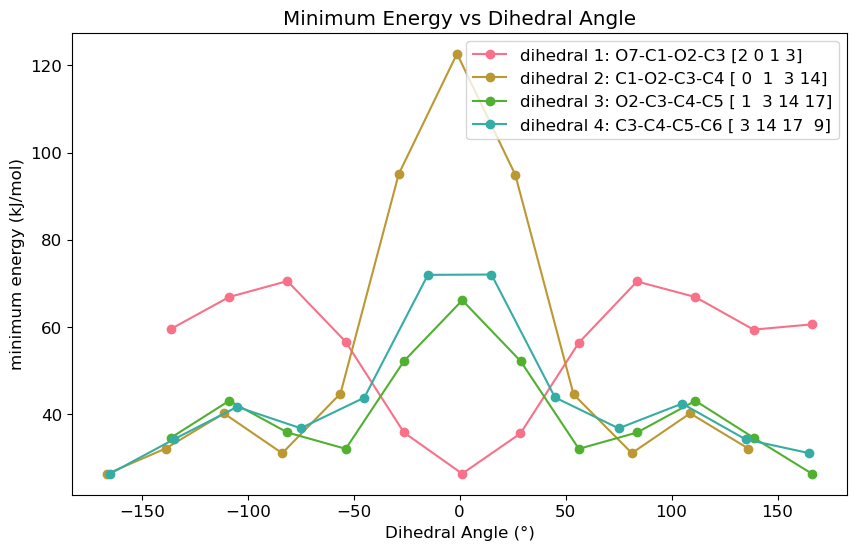

In [11]:
import scipy.stats

# Plot minimum energy vs dihedral angle for all dihedrals
for i in range(M):
    statistic, edges, binnumbers = scipy.stats.binned_statistic(angles[:, i], energies, statistic="min", bins=12)
    centers = 0.5*(edges[:-1] + edges[1:])
    atom_names = [universe.atoms[idx].name for idx in dihedral_indices[i]]
    plt.plot(centers, statistic, "o-", label=f"dihedral {i+1}: {"-".join(atom_names)} {dihedral_indices[i]}")

plt.xlabel("Dihedral Angle (°)")
plt.ylabel("minimum energy (kJ/mol)")
plt.title("Minimum Energy vs Dihedral Angle")
plt.legend()

### Boltzmann weighted energy per dihedral

For each value of the dihedral angle, we calculate the Boltzmann-weighted average energy over all conformers.
This gives us a thermodynamically weighted view of the energy landscape, where lower energy conformers
contribute more significantly to the average according to their Boltzmann factors $\mathrm{exp}(-E/kT)$.
The weighting helps identify energetically favorable regions that are thermodynamically accessible at the given temperature.
 


#### Boltzmann weighting function for `binned_statistic(..., statistic=boltzmann_weighted_average)

Set Temperature to 300 K; makes no big difference.


The improved `boltzmann_weighted_average` function handles several numerical issues:

1. **Energy Shifting First**: Subtracts the minimum energy BEFORE applying any filters - this is crucial for numerical stability
2. **Relative Energy Cutoff**: Filters out energies >500 kJ/mol **relative to the minimum** (not absolute), which is physically meaningful
3. **Error State Handling**: Uses `np.errstate` to suppress overflow/underflow warnings
4. **Fallback Strategy**: Falls back to simple arithmetic mean if Boltzmann weighting fails
5. **Input Validation**: Handles empty arrays, single values, and non-finite values gracefully

**Key Insight**: The cutoff should be applied to relative energies (energy differences), not absolute energies. This way:
- A dataset with energies [1000, 1005, 1010] kJ/mol has relative energies [0, 5, 10] kJ/mol → all valid
- A dataset with energies [0, 5, 600] kJ/mol has relative energies [0, 5, 600] kJ/mol → 600 kJ/mol excluded

This prevents RuntimeWarnings and ensures robust behavior even with problematic energy data.


In [12]:
import scipy.stats
import scipy.constants

# Define Boltzmann constant and temperature
k_B = scipy.constants.k * scipy.constants.N_A / 1000  # Boltzmann constant in kJ/(mol·K)
T = 300.0  # Temperature in K
beta = 1.0 / (k_B * T) 

def boltzmann_weighted_average(energies_in_bin, beta=beta, max_energy_cutoff=500.0):
    """
    Calculate Boltzmann-weighted average energy for energies in a bin.
    
    This function is robust against numerical issues like overflow and underflow.
    
    Parameters:
    -----------
    energies_in_bin : array-like
        Energy values in the bin
    beta : float
        1/(k_B * T) in units consistent with energies
    max_energy_cutoff : float
        Maximum relative energy to consider (kJ/mol). Energies above this 
        (relative to the minimum) are excluded to prevent numerical issues.
    
    Returns:
    --------
    float : Boltzmann-weighted average energy, or np.nan if no valid data
    """
    if len(energies_in_bin) == 0:
        return np.nan
    
    energies = np.asarray(energies_in_bin)
    
    # First filter out non-finite values
    finite_mask = np.isfinite(energies)
    if not np.any(finite_mask):
        return np.nan
    
    finite_energies = energies[finite_mask]
    
    # Shift energies by minimum to improve numerical stability
    # This also makes the cutoff relative to the minimum energy
    E_min = np.min(finite_energies)
    shifted_energies = finite_energies - E_min
    
    # Now filter based on relative energy cutoff
    valid_mask = shifted_energies <= max_energy_cutoff
    
    if not np.any(valid_mask):
        # If no valid energies after cutoff, return NaN
        return np.nan
    
    valid_shifted_energies = shifted_energies[valid_mask]
    valid_original_energies = finite_energies[valid_mask]
    
    # If only one valid energy, return it directly
    if len(valid_original_energies) == 1:
        return valid_original_energies[0]
    
    # Calculate Boltzmann weights: exp(-beta * (E - E_min))
    # Since energies are already shifted, this is just exp(-beta * shifted_E)
    with np.errstate(over='ignore', under='ignore', invalid='ignore'):
        weights = np.exp(-beta * valid_shifted_energies)
    
    # Check for numerical issues with weights
    weight_sum = np.sum(weights)
    if weight_sum == 0 or not np.isfinite(weight_sum):
        # Fallback to simple average if weights are problematic
        return np.mean(valid_original_energies)
    
    # Calculate weighted average: sum(E * w) / sum(w)
    weighted_avg = np.sum(valid_original_energies * weights) / weight_sum
    
    return weighted_avg if np.isfinite(weighted_avg) else np.mean(valid_original_energies)

#### Simple test of the weighted Boltzmann function

In [13]:
print("Testing boltzmann_weighted_average function robustness:")
print("=" * 60)

# Test cases that can cause issues
test_cases = [
    ("Empty array", []),
    ("Single value", [10.0]),
    ("Normal energies", [0.0, 5.0, 10.0, 15.0]),
    ("High absolute, low relative", [1000.0, 1005.0, 1010.0, 1015.0]),  # All within 15 kJ/mol range
    ("High absolute, high relative", [1000.0, 1005.0, 2000.0, 5000.0]),  # Large relative range
    ("Very high energies (>500 kJ/mol relative)", [0.0, 5.0, 600.0, 1000.0]),  # Relative to min
    ("All high relative energies", [0.0, 600.0, 800.0, 1000.0]),  # All above cutoff except min
    ("Mixed with NaN/inf", [0.0, 5.0, np.nan, np.inf, 10.0]),
    ("Extreme absolute range", [1e10, 1e10 + 5, 1e10 + 10, 1e10 + 15]),  # Small relative range
]

for name, test_energies in test_cases:
    try:
        result = boltzmann_weighted_average(test_energies)
        print(f"{name:25s}: {result:12.4f}")
    except Exception as e:
        print(f"{name:25s}: ERROR - {e}")

print("\nFunction returns NaN when:")
print("1. Input array is empty")
print("2. All energies are above the RELATIVE cutoff (default 500 kJ/mol above minimum)")
print("3. All energies are NaN or infinite")
print("4. Numerical issues cause weight_sum to be 0 or non-finite")

print(f"\nEnergy statistics in current dataset:")
relative_energies_all = energies - np.min(energies[np.isfinite(energies)])
print(f"  Finite energies: {np.sum(np.isfinite(energies))} / {len(energies)}")
print(f"  Valid relative energies (≤500 kJ/mol above min): {np.sum(relative_energies_all <= 500.0)} / {len(energies)}")
print(f"  High relative energies (>500 kJ/mol above min): {np.sum(relative_energies_all > 500.0)} / {len(energies)}")
print(f"  Absolute energy range: {np.min(energies[np.isfinite(energies)]):.2f} - {np.max(energies[np.isfinite(energies)]):.2e} kJ/mol")
print(f"  Relative energy range: 0.00 - {np.max(relative_energies_all[np.isfinite(relative_energies_all)]):.2e} kJ/mol")


Testing boltzmann_weighted_average function robustness:
Empty array              :          nan
Single value             :      10.0000
Normal energies          :       0.7719
High absolute, low relative:    1000.7719
High absolute, high relative:    1000.5936
Very high energies (>500 kJ/mol relative):       0.5936
All high relative energies:       0.0000
Mixed with NaN/inf       :       0.7417
Extreme absolute range   : 10000000000.7719

Function returns NaN when:
1. Input array is empty
2. All energies are above the RELATIVE cutoff (default 500 kJ/mol above minimum)
3. All energies are NaN or infinite
4. Numerical issues cause weight_sum to be 0 or non-finite

Energy statistics in current dataset:
  Finite energies: 20736 / 20736
  Valid relative energies (≤500 kJ/mol above min): 12774 / 20736
  High relative energies (>500 kJ/mol above min): 7962 / 20736
  Absolute energy range: 26.44 - 2.06e+17 kJ/mol
  Relative energy range: 0.00 - 2.06e+17 kJ/mol


#### Energy plots

Boltzmann weighting parameters:
  Temperature: 300.0 K
  k_B: 0.00831446261815324 kJ/(mol·K)
  beta = 1/(k_B*T): 0.4009 mol/kJ


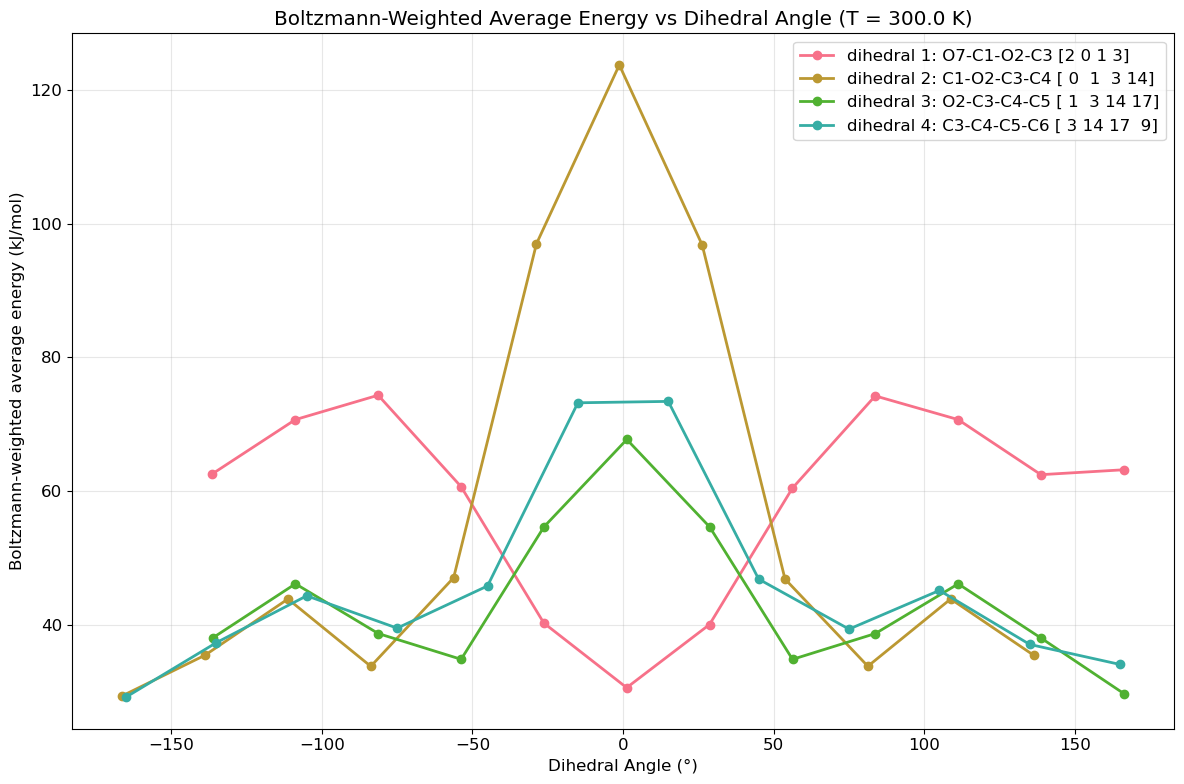

In [14]:
# Plot Boltzmann-weighted average energy vs dihedral angle for all dihedrals
plt.figure(figsize=(12, 8))

for i in range(M):
    # Use binned_statistic with custom function for Boltzmann weighting
    statistic, edges, binnumbers = scipy.stats.binned_statistic(
        angles[:, i], energies, statistic=boltzmann_weighted_average, bins=12
    )
    centers = 0.5*(edges[:-1] + edges[1:])
    atom_names = [universe.atoms[idx].name for idx in dihedral_indices[i]]
    plt.plot(centers, statistic, 'o-', linewidth=2, markersize=6,
             label=f"dihedral {i+1}: {'-'.join(atom_names)} {dihedral_indices[i]}")

plt.xlabel("Dihedral Angle (°)")
plt.ylabel("Boltzmann-weighted average energy (kJ/mol)")
plt.title(f"Boltzmann-Weighted Average Energy vs Dihedral Angle (T = {T} K)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

print(f"Boltzmann weighting parameters:")
print(f"  Temperature: {T} K")
print(f"  k_B: {k_B} kJ/(mol·K)")
print(f"  beta = 1/(k_B*T): {beta:.4f} mol/kJ")

In [15]:
statistic, edges, binnumbers = scipy.stats.binned_statistic(
        angles[:, 0], energies, statistic=boltzmann_weighted_average, bins=12
    )
statistic, edges, binnumbers

(array([62.62482592, 70.71408163, 74.36171132, 60.72133141, 40.32943624,
        30.67298853, 40.1111431 , 60.47346014, 74.26116657, 70.72416826,
        62.49216868, 63.22627658]),
 array([-150.05491523, -122.55491516,  -95.05491509,  -67.55491502,
         -40.05491495,  -12.55491489,   14.94508518,   42.44508525,
          69.94508532,   97.44508539,  124.94508545,  152.44508552,
         179.94508559]),
 array([6, 6, 6, ..., 5, 5, 5], shape=(20736,)))

## 2D Energy Density Plots

Create 2D density plots of Boltzmann-weighted energies against pairs of dihedrals:


Created 2D Boltzmann-weighted energy density plots for 6 dihedral pairs
Using T = 300.0 K, beta = 0.4009 mol/kJ


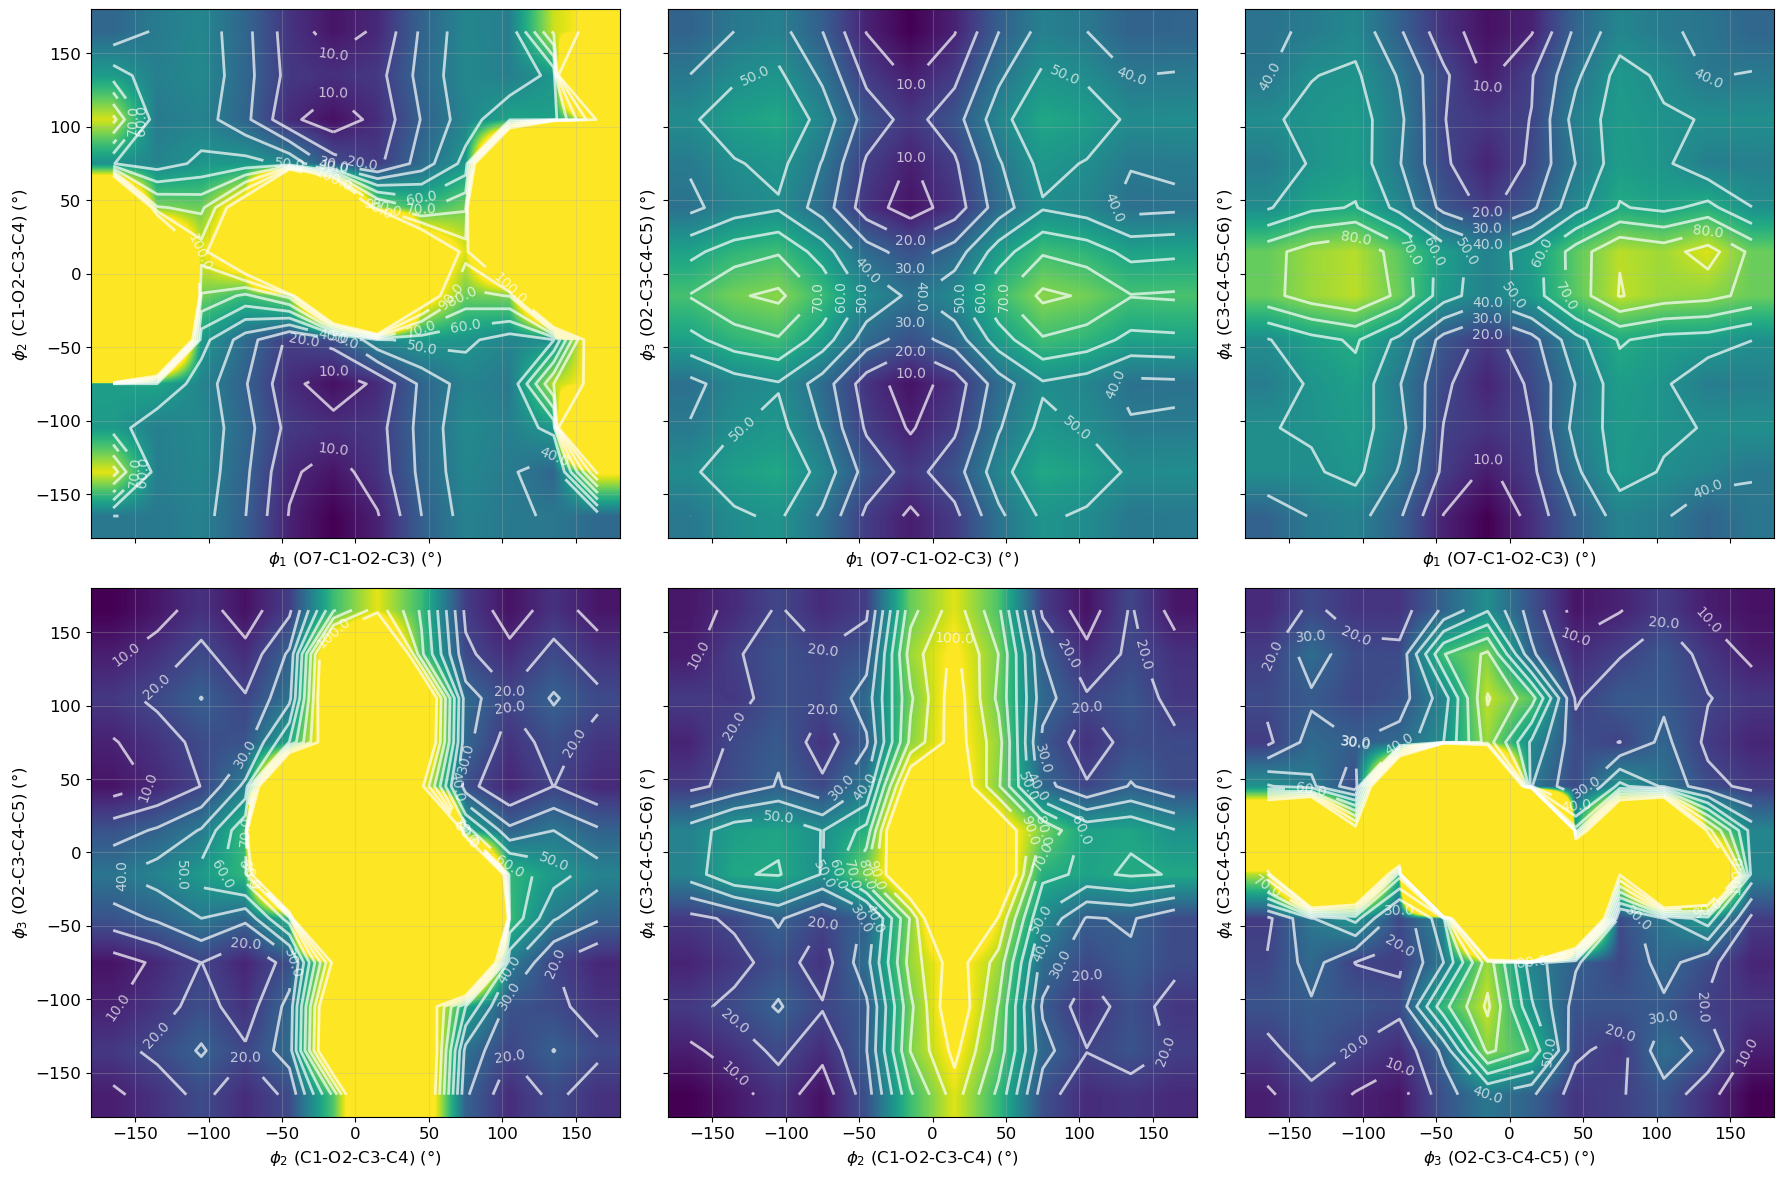

In [16]:
# Create 2D energy density plots for pairs of dihedrals using Boltzmann-weighted averaging

MAX_ENERGY = 100

if M >= 2:
    n_pairs = min(6, M * (M - 1) // 2)  # Up to 6 pairs
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
    axes = axes.flatten()
    
    pair_idx = 0
    for i in range(M):
        for j in range(i + 1, M):
            if pair_idx >= n_pairs:
                break
                
            ax = axes[pair_idx]
            
            # Get data for this pair
            x_angles = angles[:, i]  # Dihedral i angles for all conformers
            y_angles = angles[:, j]  # Dihedral j angles for all conformers
            
            # Use 2D binned statistic with Boltzmann-weighted averaging
            n_bins = 12  # Number of bins in each dimension
            statistic_2d, x_edges, y_edges, binnumber = scipy.stats.binned_statistic_2d(
                x_angles, y_angles, energies, 
                statistic=boltzmann_weighted_average, 
                bins=[n_bins, n_bins], 
                range=[[-180, 180], [-180, 180]]
            )
            statistic_2d -= np.min(statistic_2d)
            
            # Create bin centers for plotting
            x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
            y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
            X, Y = np.meshgrid(x_centers, y_centers)
            
            # Plot the binned data as a heatmap
            im = ax.imshow(statistic_2d.T, extent=[-180, 180, -180, 180], 
                          origin='lower', cmap='viridis', aspect='equal', 
                          interpolation='bilinear',
                          vmin=0, vmax=MAX_ENERGY)
            
            
            # Add contour lines for the binned data
            try:
                # Only plot contours where we have valid data (not NaN)
                valid_mask = ~np.isnan(statistic_2d)
                if np.sum(valid_mask) > 2:  # Need enough valid points
                    contours = ax.contour(X, Y, statistic_2d.T, levels=np.arange(0, MAX_ENERGY+1, 10),
                                        colors='white', alpha=0.7, linewidths=2)
                    ax.clabel(contours, inline=True, fontsize=10, fmt='%.1f')
            except:
                pass  # Skip contours if plotting fails
            
            
            # Get atom names for labels
            atom_names_i = [universe.atoms[idx].name for idx in dihedral_indices[i]]
            atom_names_j = [universe.atoms[idx].name for idx in dihedral_indices[j]]
            
            ax.set_xlabel(f'$\phi_{{{i+1}}}$ ({"-".join(atom_names_i)}) (°)')
            ax.set_ylabel(f'$\phi_{{{j+1}}}$ ({"-".join(atom_names_j)}) (°)')
            ax.set_xlim(-180, 180)
            ax.set_ylim(-180, 180)
            ax.grid(True, alpha=0.3)
            
            pair_idx += 1
        
        if pair_idx >= n_pairs:
            break
    
    # Hide unused subplots
    for i in range(pair_idx, 6):
        axes[i].set_visible(False)

    # Colorbar (should be located outside of the figure)
    # cbar = plt.colorbar(im, ax=axes, location='right', pad=0.02)
    # cbar.set_label('kJ/mol', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'energy_2d_boltzmann_density_plots.png', dpi=300, bbox_inches='tight')
    
    print(f"Created 2D Boltzmann-weighted energy density plots for {pair_idx} dihedral pairs")
    print(f"Using T = {T} K, beta = {beta:.4f} mol/kJ")
else:
    print("Need at least 2 dihedrals for 2D plots. Only found", M, "dihedral(s).")

## Finding minima

In [17]:
import molconfgen.minima

from importlib import reload
reload(molconfgen.minima)

<module 'molconfgen.minima' from '/Volumes/ASU/oliver/Projects/Methods/SmallMoleculeSolvation/mdpow-molconfgen/molconfgen/minima.py'>

In [ ]:
import molconfgen

xxx = molconfgen.minima.griddata_interpolate(
    points=angles,
    energies=energies,
    grid_shape=angles.shape[1] * [20],
)

In [220]:
reload(molconfgen.minima)

<module 'molconfgen.minima' from '/Volumes/ASU/oliver/Projects/Methods/mdpow-molconfgen/molconfgen/minima.py'>

### Improving finding minima code

At the moment much too slow as implemented in minima.py.

I am trying to directly use scipy's grid nearest neighbor interpolation so that I can ensure that the dihedral angles are defined on a regular grid. We will make use of [scipy's scipy.interpolate.NearestNDinterpolator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.NearestNDInterpolator.html#Scipy.Interpolate.NearestNDinterpolator) because we can tell the underlying cKDTree to use periodicity (thus we don't have to augment data at boundaries ourselves).

Our approach will be to
1. generate an exact dihedral angle grid with `num_conformers` grid point in the half-open interval $[-180º, 180º)$
2. interpolate (angles, energies) on this grid with periodic NearestNeighbor interpolation
3. use the interpolation to generate a tensor of the energy data associated with the regular grid
4. use `minima.find_minima()` on this tensor



Previous "new" plan:
1. use nearest-neighbor interpolation (with periodic KDTree, so should not need augmentation) to generate augmented data on an exact lattice ($\Delta\phi = 360º/N$), _including_ points outside the boundary. 
2. then try the regular grid interpolator (see if it's sufficiently fast) with linear or cubic interpolation
3. interpolate on a finer grid (DO WE NEED TO??)
4. find minima

#### Re-wrap


In [22]:
# We need to rewrap from [-180, 180) to [0, 360) because the PBC-aware KDTree only works with positive values
angles360 = molconfgen.minima.wrap_angles(angles, lower=0, upper=360)


As an example, find all nearest neighbors with a cutoff similar to 360/num_conformers, i.e., the approximate spacing of the dihedral angles.

In [19]:
ptree = scipy.spatial.KDTree(angles360, boxsize=angles.shape[1] * [360])
ptree.query_ball_point(angles360, r=30)

array([list([0, 144, 1584]), list([1, 145, 1585]), list([2, 146, 1586]),
       ..., list([19005, 19149, 20601, 20721, 20733, 20734]),
       list([19006, 19150, 20602, 20722, 20733, 20734]),
       list([19007, 19151, 20603, 20723, 20724, 20735])],
      shape=(20736,), dtype=object)

#### Interpolation

In [41]:
num_conformers = 12

grid_shape = angles.shape[1] * [num_conformers]
#grid_vectors, E = molconfgen.minima.regular_grid(shape=grid_shape, lower=-180, upper=180)
grid_vectors, E = molconfgen.minima.regular_grid(shape=grid_shape, lower=0, upper=360)

print(grid_vectors)
print(E.shape)


[array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330.]), array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330.]), array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330.]), array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330.])]
(12, 12, 12, 12)


Do we want to interpolate probailities?

In [ ]:
import scipy.stats
import scipy.constants

# Define Boltzmann constant and temperature
k_B = scipy.constants.k * scipy.constants.N_A / 1000  # Boltzmann constant in kJ/(mol·K)
T = 300.0  # Temperature in K
beta = 1.0 / (k_B * T) 

p_i = np.exp(-beta * (energies - energies.min()))
p_i /= p_i.sum()

p_i.max()

np.float64(0.4262277719547327)

Testing shows that energies works just as well with NN. We will just shift them.

Shift energy before interpolating

In [50]:
energy_shifted = energies - energies.min()


##### Manual interpolation code

In [51]:
import scipy.interpolate


num_conformers = 12

# We need to rewrap from [-180, 180) to [0, 360) because the PBC-aware KDTree only works with positive values
angles360 = molconfgen.minima.wrap_angles(angles, lower=0, upper=360)

grid_shape = angles360.shape[1] * [num_conformers]
grid_vectors, E = molconfgen.minima.regular_grid(shape=grid_shape, lower=0, upper=360)

mesh = np.meshgrid(*grid_vectors, indexing="ij")
xi = np.stack([m.ravel() for m in mesh], axis=-1)


# periodic nearest neighbor interpolation
ndi = scipy.interpolate.NearestNDInterpolator(angles360, energy_shifted, tree_options={"boxsize": 360.})

interp_vals = ndi(xi, workers=-1)
E[:, :] = interp_vals.reshape(grid_shape)

In [58]:
grid_vectors

[array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
        330.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
        330.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
        330.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
        330.])]

In [53]:
E.min(), E.max()

(np.float64(0.0), np.float64(2.0602164408955696e+17))

#### Interpolation with minima.nearest_neighbor_interpolate

In [66]:
import molconfgen.minima
reload(molconfgen.minima)


grid_vectors, E = molconfgen.minima.nearest_neighbor_interpolate(angles, energies, num_conformers=12)

E, grid_vectors = molconfgen.minima.wrap_tensor(E, grid_vectors, lower=-180, upper=180)

E.min(), E.max()

(np.float64(0.0), np.float64(2.0602164408955696e+17))

In [62]:
def marginalize_except(arr, axis_to_keep, agg_func=np.nanmin):
    """
    Marginalize (aggregate) over all axes except one, using the specified aggregation function.

    Parameters:
        arr (np.ndarray): The input array.
        axis_to_keep (int): The axis to keep (not reduce).
        agg_func (callable): Aggregation function, e.g., np.mean, np.min, np.max.

    Returns:
        np.ndarray: The marginalized array, shape will be (arr.shape[axis_to_keep],)
    """
    # Handle negative axis
    axis_to_keep = axis_to_keep % arr.ndim
    axes = tuple(ax for ax in range(arr.ndim) if ax != axis_to_keep)
    return agg_func(arr, axis=axes)

def boltzmann_weighted_avg(a, axis=None, beta=1.0):
    """
    Compute the boltzmann weighted average of an array.
    """
    return np.sum(a * np.exp(-beta * a), axis=axis) / np.sum(np.exp(-beta * a), axis=axis)


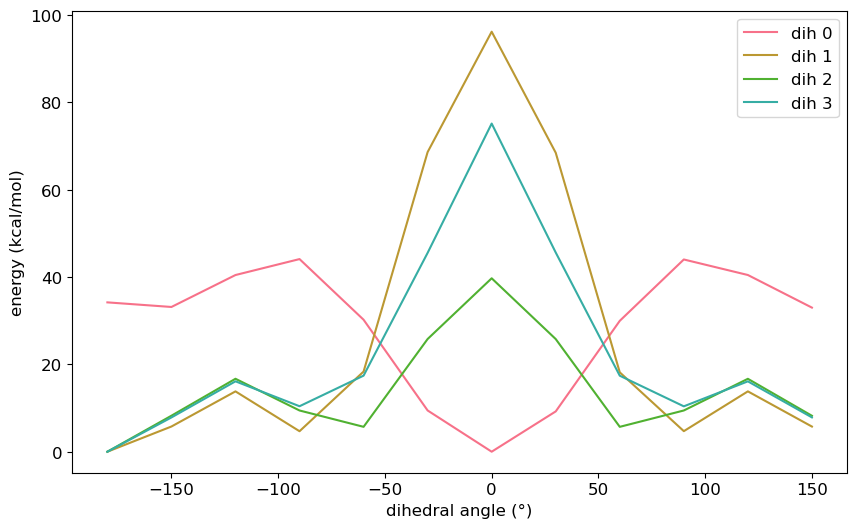

In [67]:
num_dihedrals = angles.shape[1]
E_dih = []
for idih in range(num_dihedrals):
    E_dih.append(marginalize_except(E, axis_to_keep=idih))
E_dih = np.array(E_dih)

for idih in range(num_dihedrals):
    phi = grid_vectors[idih]
    plt.plot(phi, E_dih[idih, :], label=f"dih {idih}")

plt.xlabel("dihedral angle (°)")
plt.ylabel("energy (kcal/mol)")
plt.legend()

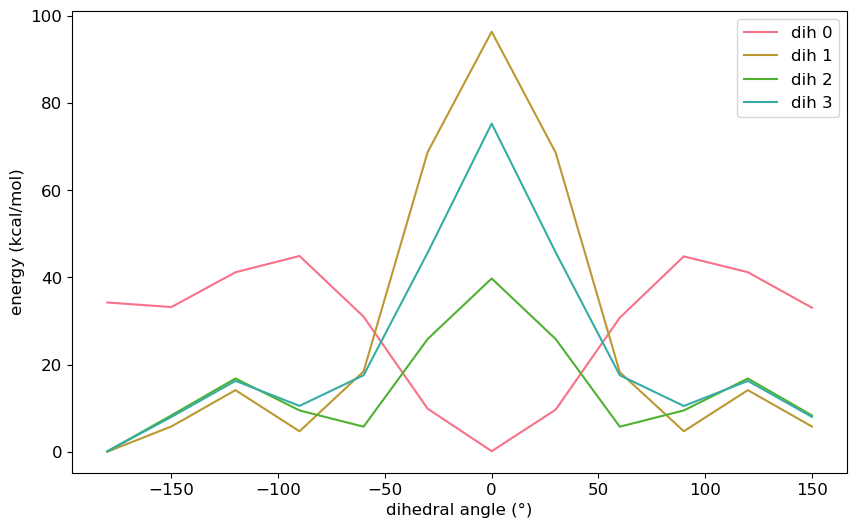

In [68]:
num_dihedrals = angles.shape[1]
E_dih = []
for idih in range(num_dihedrals):
    E_dih.append(marginalize_except(E, axis_to_keep=idih, agg_func=boltzmann_weighted_avg))
E_dih = np.array(E_dih)

for idih in range(num_dihedrals):
    phi = grid_vectors[idih]
    plt.plot(phi, E_dih[idih, :], label=f"dih {idih}")

plt.xlabel("dihedral angle (°)")
plt.ylabel("energy (kcal/mol)")
plt.legend()

In [69]:
grid_vectors

[array([-180., -150., -120.,  -90.,  -60.,  -30.,    0.,   30.,   60.,
          90.,  120.,  150.]),
 array([-180., -150., -120.,  -90.,  -60.,  -30.,    0.,   30.,   60.,
          90.,  120.,  150.]),
 array([-180., -150., -120.,  -90.,  -60.,  -30.,    0.,   30.,   60.,
          90.,  120.,  150.]),
 array([-180., -150., -120.,  -90.,  -60.,  -30.,    0.,   30.,   60.,
          90.,  120.,  150.])]